توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




__Explanation of transformations:__ It is assumed that the input images are PyTorch tensors (with shape $N×C×H×W$)

1.   __Displacement:__ We use a RandomAffine transformation, but we set the rotation to zero, as this was the only good function having displacement options. The translations in both dimensions are selected randomly in $\pm20\%$. Then, the image is cropped to have no invalid part.
2.   __Rotation:__ A rotation degree between $15°$ and $30°$ is used. The reason is if the range includes zero, even for small rotations, the rotation label with be 1, but the rotation detection may be hard for the network. For the cropping part, we use a formula assuming the picture is square, and then generalize to rectangle by taking min(height,width). For a square, we have: <br>
$$L^\prime *\cos(\theta)+L^\prime *\sin(\theta)=L \Rightarrow L^\prime=\frac{L}{ \cos(\theta)+\sin(\theta)}$$
3. __Scaling:__ The image is center-cropped with a random ratio (for width and height separately) between 0.7 and 1.
4. __Blurring:__ A gaussian blurring is used
5. __Brightness:__ Colorjitter transform with 0.3 max brightness change
6. __Gaussian noise:__ First, the maximum pixel of the image is calculated and we set $\sigma=0.07\times max$. Then, we add a zero-mean Gaussian noise with the aforementioned $\sigma$.




In [3]:
import torchvision.transforms.functional as vision_F
import time

# function 1
def displacement(img):

    t=transforms.RandomAffine(degrees=0, translate=(0.2,0.2), fill=0)
    img_size = (img.shape[2], img.shape[1])
    ret = transforms.RandomAffine.get_params(t.degrees, t.translate, t.scale, t.shear, img_size)
    (dw,dh)=ret[1]
    img=vision_F.affine(img, *ret)
    img=vision_F.crop(img, top=max(dh,0) , left=max(dw,0), height=img_size[1]-abs(dh), width=img_size[0]-abs(dw))
    return img

# function 2
def rotation(img):
    ''' For square images, rotating followed by cropping is equivalent to cropping an inner tilted square.
    In this case, we have: L2=L/(sin(theta)+cos(theta)).
    So, we have used this formula (with taking the integer value, of course) to calculate the crop size
    '''

    t=transforms.RandomRotation(degrees=(15,30), expand=False, fill=0)
    img_size = (img.shape[2], img.shape[1])
    angle = t.get_params(t.degrees)
    L=min(img_size)
    img=vision_F.rotate(img, angle, expand=t.expand, center=t.center, fill=t.fill)
    new_L=int(L/(np.cos(angle*np.pi/180)+np.sin(np.abs(angle)*np.pi/180)) )#(It is better if it is a square input)
    img=vision_F.center_crop(img, output_size=new_L)
    return img


# function 3
def scaling(img):

    img_size = (img.shape[2], img.shape[1])
    scale_w=random.randint(int(0.7*img_size[0]), img_size[0])
    scale_h=random.randint(int(0.7*img_size[1]), img_size[1])
    img=vision_F.center_crop(img, output_size=(scale_h,scale_w))
    return img



# function 4
def Brightness(img):  ## for augmentation
    t=transforms.ColorJitter(brightness=0.3, contrast=0, saturation=0, hue=0)
    img=t.forward(img)
    return img


# function 5
def bluring(img):# for augmentation
    t=transforms.GaussianBlur(kernel_size=5)
    img=t.forward(img)
    return img

# function 6
def gaussian_noise(img):#for augmentation
    coeff=0.07
    sigma=coeff*torch.amax(img, dim=tuple(range(0,img.dim())) ).item() #Redundant on torch ToTensor() output given to it
    img=img+sigma*torch.randn_like(img)
    return img

__Dataset class explanation:__ The path for file loading is relative to the notebook folder, and is selected based on the loader type (test, train, validation). Also, a function is provided that given an index, creates the full path and file name of the corresponding image.<br>
In the getitem function, the image is selected by the index and loaded. Note that the test set has some missing values (On my laptop, there were 3352 images but the maximum number was 3489). For this reason, if we cannot get the image, we sample randomly from the dataset until we find a valid image.<br>
After that, with $p=0.3$, one of the 3 augmentation transforms are performed on the image. <br>
Next, we produce a random number to indicate the number of main transforms, which is between 0 and 3. According to the value, we select the labels randomly with a sum value constraint and then apply the transformations. Note that the one-hot vector in the code is only a convenient way to do this in labels of size 3. <br>
Finally, the image is resized to $224\times 224$ after the main transformations.


In [4]:
class CustomDataset(Dataset):
    _train_path='ADEChallengeData2016/images/training/ADE_train_'
    _valid_path='ADEChallengeData2016/images/validation/ADE_val_'
    _test_path='release_test/testing/ADE_test_'
    _format='.jpg'
    _fill=8
    _transform_numbers=3
    _transform_list=[displacement,rotation,scaling]
    def __init__(self, type, device):
        self.device=device
        self.train=(type=='Train')
        self.valid=(type=='Validation')
        self.test=(type=='Test')
        self.transform=transforms.ToTensor()
        self.Resize=transforms.Resize((224,224),antialias=True)

    def create_path(self,idx):
        idx_str=str(idx+1).zfill(CustomDataset._fill)
        if self.train:
            path=CustomDataset._train_path+idx_str+CustomDataset._format
        elif self.valid:
            path=CustomDataset._valid_path+idx_str+CustomDataset._format
        else: #Test
            path=CustomDataset._test_path+idx_str+CustomDataset._format
        return path

    def __getitem__(self, idx):
        path=self.create_path(idx)
        im=IM(path)

        while im is None:#The test dataset has some missing images, so we have to handle that
            rand_index=random.randint(0,self.__len__()-1)
            rand_path=self.create_path(rand_index)
            im=IM(rand_path)

        tensor_im=self.transform(im)
        tensor_im.requires_grad=False
        index=random.randint(0,2)
        num=random.randint(0,3)# If we use 0,1,2 numbers as instructed by the TA, the labels will be imbalanced
        one_hot_random=nn.functional.one_hot(torch.tensor(index),CustomDataset._transform_numbers)
        label=torch.zeros(CustomDataset._transform_numbers)


        p=random.random()
        if p>0.3:
            transformed_im=tensor_im
        elif (p>=0) and (p<=0.1):
            transformed_im=Brightness(tensor_im)
        elif (p>0.1) and (p<=0.2):
            transformed_im=bluring(tensor_im)
        else: # p>0.2 and p<=0.3:
            transformed_im=gaussian_noise(tensor_im)

        if num==1:
            transformed_im=CustomDataset._transform_list[index](tensor_im)
            label=one_hot_random
        elif num==2:
            label=1-one_hot_random
            copy=CustomDataset._transform_list.copy()
            copy.pop(index)
            transformed_im=copy[1](copy[0](tensor_im))
        elif num==3:
            label=1-label
            transformed_im=CustomDataset._transform_list[2](CustomDataset._transform_list[1](CustomDataset._transform_list[0](tensor_im)))
        unchanged=self.Resize(tensor_im)
        transformed_im=self.Resize(transformed_im)

        return label,unchanged,transformed_im

    def __len__(self):
        if self.train:
            return 20210
        elif self.valid:
            return 2000
        return 3489 #Test

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_train = CustomDataset('Train',device)## To Do
dataset_test = CustomDataset('Test',device)## To Do
dataset_val = CustomDataset('Validation',device)## To Do


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)## To Do
test_loader= DataLoader(dataset_test, batch_size=16, shuffle=True)## To Do
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)## To Do

Note that in the images below, the augmentation transforms are performed on both images.

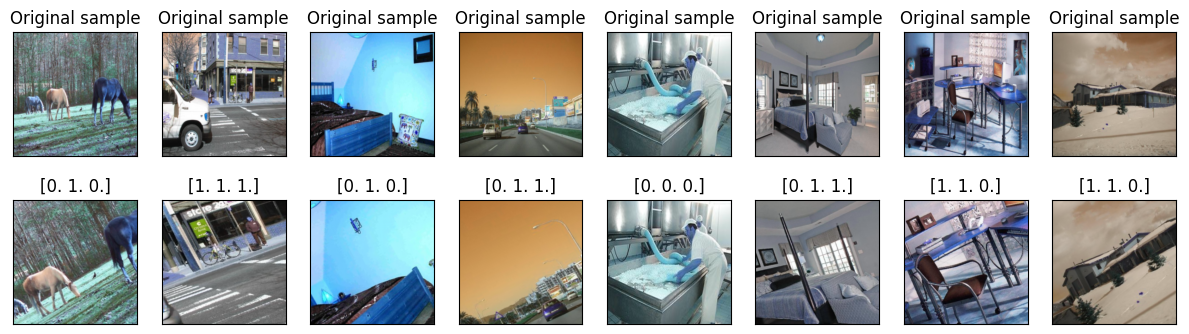

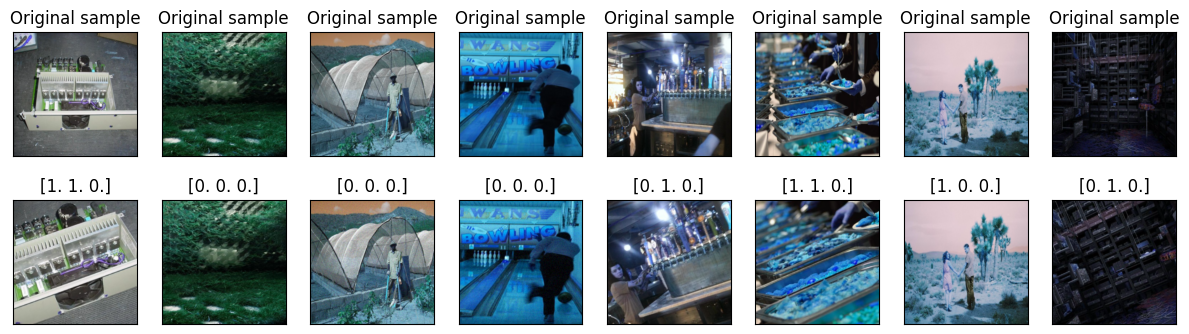

In [6]:
## To Do  : show 8 images from train_loader & 8 images from test_loader
train_labels,train_images,train_transformed_images=next(iter(train_loader))[:8]
test_labels,test_images,test_transformed_images=next(iter(test_loader))[:8]

def plot_eight_images(labels,images,transformed_images):
    fig,axs=plt.subplots(2,8,figsize=(15,4))

    for i in range(8):
        image=images[i]
        label=labels[i]
        transformed=transformed_images[i]
        image_clone=image.clone().permute(1,2,0)
        transformed_clone=transformed.clone().permute(1,2,0)
        axs[0][i].get_xaxis().set_visible(False)
        axs[0][i].get_yaxis().set_visible(False)
        axs[0][i].title.set_text('Original sample')
        axs[0][i].imshow(image_clone)

        axs[1][i].get_xaxis().set_visible(False)
        axs[1][i].get_yaxis().set_visible(False)
        axs[1][i].title.set_text(str(label.detach().numpy()))
        axs[1][i].imshow(transformed_clone)
    plt.show()
plot_eight_images(train_labels,train_images,train_transformed_images)
plot_eight_images(test_labels,test_images,test_transformed_images)

## Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

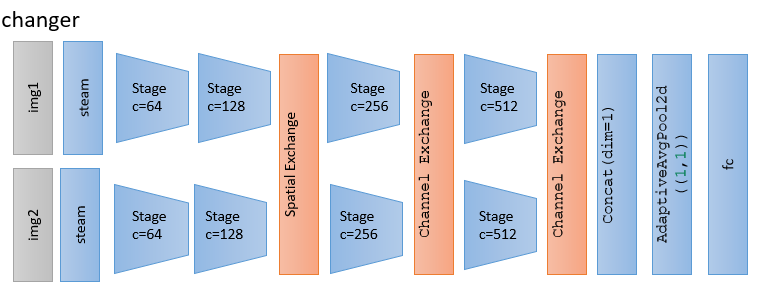

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


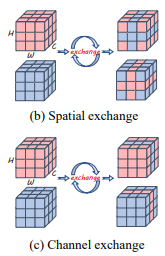

In [7]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

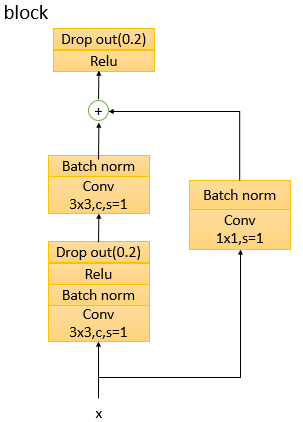

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





1. The $1\times 1$ conv output and the main block output must be of the same size so that we can add them. For this reason, we set padding=1 (For kernel size=3, this is equivalent to 'same' convolution) and output channels of the $1\times 1$ conv equal to c.
2. Calculating weighted averages on each channel, and changing the feature size (either to increase of decrease it).

In [8]:
##To Do
class block(nn.Module):
    def __init__(self,in_C,C,device='cpu'):
        super(block,self).__init__()
        self.C=C
        self.in_C=in_C
        self.device=device
        self.conv11=nn.Sequential(
            nn.Conv2d(in_channels=in_C,out_channels=C,kernel_size=1,stride=1,padding=0,device=device),
            nn.BatchNorm2d(C,device=device)
        )

        self.parallelblock=nn.Sequential(
            nn.Conv2d(in_channels=in_C,out_channels=C,kernel_size=3,stride=1,padding=1,device=device),
            nn.BatchNorm2d(C,device=device),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=C,out_channels=C,kernel_size=1,stride=1,padding=0,device=device),
            nn.BatchNorm2d(C,device=device)
        )
        self.final=nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )


    def forward(self,x):
        out=self.final(self.conv11(x)+self.parallelblock(x))
        return out

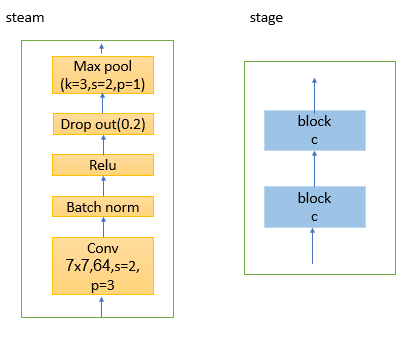

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [9]:
#To Do
class changer(nn.Module):
    def __init__(self, block, SpatialExchange, ChannelExchange):
        super(changer,self).__init__()

        self.steam=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1)
            )

        self.stage1=self._make_stage(64,64)
        self.stage2=self._make_stage(64,128)
        self.stage3=self._make_stage(128,256)
        self.stage4=self._make_stage(256,512)
        self.SpatialExchange=SpatialExchange()
        self.ChannelExchange=ChannelExchange()

        self.adaptive_avg_pool=nn.AdaptiveAvgPool2d((1,1))

        self.fc=nn.Sequential(
            nn.Linear(1024,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32,3)
        )

    def _make_stage(self,in_C,C):
        layers=[block(in_C,C),block(C,C)]
        return nn.Sequential(*layers)

    def forward(self,x1,x2):
        y1=self.stage2(self.stage1(self.steam(x1)))
        y2=self.stage2(self.stage1(self.steam(x2)))

        y1,y2=self.SpatialExchange(y1,y2)

        y1=self.stage4(self.stage3(y1))
        y2=self.stage4(self.stage3(y2))

        y1,y2=self.ChannelExchange(y1,y2)

        features=torch.cat((y1,y2),dim=1)
        features=torch.flatten(self.adaptive_avg_pool(features),start_dim=1)

        out=self.fc(features)
        return out

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model=changer(block,SpatialExchange,ChannelExchange).to(device)

criterion = nn.BCEWithLogitsLoss(reduction='mean')##Binary cross entropy with sigmoid loss, for multilabel classification
optimizer=torch.optim.Adam(model.parameters()) ## optimizer

## Train & validation


The network output is logits, and sigmoid and binary cross entropy loss are combined in BCEWithLogitsLoss.
For this reason, the decision boundary for the logits is 0, corresponding to p=0.5. <br>
Also, the final model which will be saved is the one that has the lowest validation set loss.

In [11]:
Loss_train=[]
Loss_val=[]
epoch_nums=5
for epoch in range(epoch_nums):
    print("Epoch: %i"%(epoch+1))
    model.train()
    Sum_loss = 0.0
    correct_train=0
    mytime=time.time()
    for i,data in enumerate(train_loader,0):
        (train_labels,train_images,train_transformed_images)=data
        output=model(train_images.to(device),train_transformed_images.to(device))
        loss=criterion(output,train_labels.float().to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        Sum_loss+=loss.item()/len(train_loader)
        train_predictions=torch.ge(output,0.5).float()
        correct_train+=torch.sum(torch.eq(train_predictions,train_labels.to(device)).float()).cpu().item()
        if i%50==49:
            print('50 Iterations. Time Elapsed: ',time.time()-mytime)
            mytime=time.time()

    model.eval()
    correct_val=0
    total_val=0
    loss_val=0
    with torch.no_grad():
        for data in val_loader:
            (val_labels,val_images,val_transformed_images)=data
            output=model(val_images.to(device),val_transformed_images.to(device))
            loss_val+=criterion(output,val_labels.float().to(device))/len(val_loader)
            val_predictions=torch.ge(output,0).float()
            correct_val+=torch.sum(torch.eq(val_predictions,val_labels.to(device)).float()).cpu().item()

    Loss_train.append(Sum_loss)
    Loss_val.append(loss_val)
    num_correct_val=correct_val/len(dataset_val)/CustomDataset._transform_numbers*100
    num_correct_train=correct_train/len(dataset_train)/CustomDataset._transform_numbers*100

    min_loss_val=min(Loss_val)
    if min_loss_val==loss_val:
        checkpoint={
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': Sum_loss,
            'val_loss': loss_val,
            }



    print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')

print('Finished Training the full network')
torch.save(checkpoint,'Model')

Epoch: 1
50 Iterations. Time Elapsed:  109.07143187522888
50 Iterations. Time Elapsed:  102.48419237136841
50 Iterations. Time Elapsed:  104.04636669158936
50 Iterations. Time Elapsed:  114.04618167877197
50 Iterations. Time Elapsed:  109.42317032814026
50 Iterations. Time Elapsed:  109.88829302787781
50 Iterations. Time Elapsed:  108.26315593719482
50 Iterations. Time Elapsed:  110.09559845924377
50 Iterations. Time Elapsed:  112.61844182014465
50 Iterations. Time Elapsed:  103.99107646942139
50 Iterations. Time Elapsed:  104.68932390213013
50 Iterations. Time Elapsed:  103.12754416465759
loss_TRAIN =0.416,acc_train=75.80240804882071,	 loss_val= 0.390, acc_val=80.06666666666668
Epoch: 2
50 Iterations. Time Elapsed:  102.27868580818176
50 Iterations. Time Elapsed:  102.29834508895874
50 Iterations. Time Elapsed:  104.19250297546387
50 Iterations. Time Elapsed:  103.70750689506531
50 Iterations. Time Elapsed:  103.43580842018127
50 Iterations. Time Elapsed:  104.89946794509888
50 Iterat

In [12]:
torch.save(checkpoint,'model.pt')

# Test


In [25]:
checkpoint = torch.load('model.pt')
model=changer(block,SpatialExchange,ChannelExchange).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer=torch.optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
val_loss= checkpoint['val_loss']

model.eval()
correct_test=0
total_test=0
loss_test=0
acc_tensor=torch.zeros(CustomDataset._transform_numbers)
correct_per_sum=np.zeros(4)
total_per_sum=np.zeros(4)
with torch.no_grad():
    for data in test_loader:
        (test_labels,test_images,test_transformed_images)=data
        output=model(test_images.to(device),test_transformed_images.to(device))
        loss_test+=criterion(output,test_labels.float().to(device))/len(test_loader)
        test_predictions=torch.ge(output,0).float()
        new_acc_tensor=torch.sum(torch.eq(test_predictions,test_labels.to(device)).float(),dim=0).cpu()
        acc_tensor+=new_acc_tensor
        correct_test+=torch.sum(new_acc_tensor).item()

        sum=torch.sum(test_labels,dim=1)

        labels_0=test_labels[sum==0].to(device)
        labels_1=test_labels[sum==1].to(device)
        labels_2=test_labels[sum==2].to(device)
        labels_3=test_labels[sum==3].to(device)
        pred_0=test_predictions[sum==0].to(device)
        pred_1=test_predictions[sum==1].to(device)
        pred_2=test_predictions[sum==2].to(device)
        pred_3=test_predictions[sum==3].to(device)

        correct_per_sum[0]+=torch.sum(torch.ge(torch.sum(torch.eq(pred_0,labels_0).float(),dim=1),3).float(),dim=0).cpu().item()
        correct_per_sum[1]+=torch.sum(torch.ge(torch.sum(torch.eq(pred_1,labels_1).float(),dim=1),3).float(),dim=0).cpu().item()
        correct_per_sum[2]+=torch.sum(torch.ge(torch.sum(torch.eq(pred_2,labels_2).float(),dim=1),3).float(),dim=0).cpu().item()
        correct_per_sum[3]+=torch.sum(torch.ge(torch.sum(torch.eq(pred_3,labels_3).float(),dim=1),3).float(),dim=0).cpu().item()

        total_per_sum[0]+=labels_0.shape[0]
        total_per_sum[1]+=labels_1.shape[0]
        total_per_sum[2]+=labels_2.shape[0]
        total_per_sum[3]+=labels_3.shape[0]


acc_test=correct_test/len(dataset_test)/CustomDataset._transform_numbers*100
acc_tensor=acc_tensor/len(dataset_test)
acc_per_sum=correct_per_sum/total_per_sum*100
print(f' loss_test= {loss_test:.3f}, acc_test={(acc_test)}')
print('Accuracy on displacement, rotation and scaling= ',acc_tensor)

 loss_test= 0.350, acc_test=81.96235788669152
Accuracy on displacement, rotation and scaling=  tensor([0.7515, 0.9625, 0.7449])


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

In [26]:
print('Accuracy for number of transformations from 0 to 3= ',acc_per_sum)

Accuracy for number of transformations from 0 to 3=  [100.          10.77777778  32.27272727  93.23843416]


It is evident that the network is sensitive, and it does best when the transformation numbers are higher. Note on the calculation of the different accuracy types:
The accuracy for transformation number is based on the whole set of (three) labels being correct, and the results show that the network may detect the wrong transformation, but for a specific one (e.g. rotation) the accuracy is high.